In [1]:
import ast
import glob
import csv
import numpy as np

def parse_logs(log_directory="logs/*.log", output_csv="summary_0825.csv"):
    """
    Parse all log files in the specified directory to summarize each model's results:
      - model name (e.g., 'random_forest', 'neural_network')
      - Mean Squared Error (MSE)
      - R2 Score
      - Top 200 rsIDs

    Saves a row for each (file, model) combination to summary.csv:
      Log File | Model | MSE | R2 Score | Top 200 rsIDs
    """

    # We'll store multiple results (one per model) from each file
    all_results = []

    log_files = glob.glob(log_directory)
    for log_file in log_files:
        # Data structure to store partial results for any model
        # Key: model_name -> { "mse": ..., "r2": ..., "rsIDs": [...] }
        current_models = {}
        # Track the current model name while we parse
        active_model = None

        with open(log_file, "r", encoding="utf-8") as f:
            for line in f:
                line_content = line.split("INFO")[-1].strip()
                
                # 1) Detect a line with 'method': ...
                if "'method':" in line_content:
                    try:
                        parsed_dict = ast.literal_eval(line_content)
                        # Example: {'method': 'random_forest', 'model_params': {...}, ...}
                        model_name = parsed_dict.get("method")
                        # Initialize a new record if not seen before
                        if model_name not in current_models:
                            current_models[model_name] = {
                                "mse": None,
                                "r2": None,
                                "rsIDs": []
                            }
                        active_model = model_name
                    except (ValueError, SyntaxError):
                        pass

                # 2) Detect a line with MSE, R² dictionary
                #    Example: {'Mean Squared Error': 1.0039, 'R2 Score': 0.2845}
                if "'Mean Squared Error':" in line_content and "'R2 Score':" in line_content:
                    try:
                        parsed_dict = ast.literal_eval(line_content)
                        mse_value = parsed_dict.get("Mean Squared Error")
                        r2_value = parsed_dict.get("R2 Score")
                        if active_model is not None:
                            current_models[active_model]["mse"] = mse_value
                            current_models[active_model]["r2"] = r2_value
                    except (ValueError, SyntaxError):
                        pass

                # 3) Detect a line with the rsID list
                #    Example: ['rs10004266', 'rs10005919', 'rs10010272', ...]
                #    Usually lines look like: 2025-01-02 13:36:06,674 INFO     ['rs10004266', 'rs1000...']
                if "INFO     ['rs" in line:
                    try:
                        parsed_list = ast.literal_eval(line_content)
                        if active_model is not None and isinstance(parsed_list, list):
                            if not current_models[active_model]["rsIDs"]:  # Only update if rsIDs is empty
                                current_models[active_model]["rsIDs"] = parsed_list[:1000]
                            print(f"Captured rsIDs for {active_model}: {parsed_list[:5]}")  # Debug
                    except (ValueError, SyntaxError):
                        print(f"Failed to parse rsIDs: {line_content}")


        # After parsing the file, append each model's results
        for model_name, data in current_models.items():
            # Only add it if we actually captured MSE, R2, and rsIDs
            if data["mse"] is not None and data["r2"] is not None and data["rsIDs"]:
                all_results.append({
                    "filename": log_file,
                    "model": model_name,
                    "mse": data["mse"],
                    "r2": data["r2"],
                    "rsIDs": data["rsIDs"]
                })

    # Write summary to CSV
    with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        # Header
        writer.writerow(["Log File", "Model", "MSE", "R2 Score", "Top 1000 rsIDs"])
        for entry in all_results:
            writer.writerow([
                entry["filename"],
                entry["model"],
                entry["mse"],
                entry["r2"],
                ", ".join(entry["rsIDs"])
            ])

    print(f"Summary written to {output_csv}")
   


In [2]:
 parse_logs("../logs/sup_new/*.log", "summary_0825.csv")

Summary written to summary_0825.csv


In [3]:
import pandas as pd

# Mocking up an example of reading a CSV file and processing it since the actual file isn't provided.
# Replace this with your file path and ensure the CSV file is structured correctly.

# Example CSV content to simulate reading from a file
file = r"C:\Users\gqu\OneDrive - UTHealth Houston\projects\Genevic\scirpt\Notebook\summary_new.csv"

# Create a DataFrame
df = pd.read_csv(file)

# Group by "Model" and extract MSE and R² lists for each model
grouped = df.groupby("Model")
mse_r2_by_model = {
    model: {"MSE": group["MSE"].tolist(), "R2": group["R2 Score"].tolist()}
    for model, group in grouped
}

# Display the grouped MSE and R2 values
for model in mse_r2_by_model:
    print(model)
    print("mse:", np.mean(mse_r2_by_model[model]['MSE']), np.std(mse_r2_by_model[model]['MSE']))
    print("r2:", np.mean(mse_r2_by_model[model]['R2']), np.std(mse_r2_by_model[model]['R2']))
    print()

decision_tree
mse: 1.225432122448864 0.037927798588753926
r2: 0.12483434993584949 0.027086858504326575

lasso
mse: 1.3993598618220466 0.0
r2: 0.0006205478783868 0.0

linear_regression
mse: 1.9733703717722306 2.220446049250313e-16
r2: -0.4093199717811751 0.0

neural_network
mse: 0.8982887827177439 0.009661883834553167
r2: 0.3584699861617067 0.006900218047176154

random_forest
mse: 1.021434615614663 0.005303292015934338
r2: 0.27052304815868355 0.0037874468275976196

ridge
mse: 1.9370294359104687 0.0
r2: -0.3833664014652269 0.0

svr
mse: 1.159247692473081 2.220446049250313e-16
r2: 0.1721012190041509 0.0



In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from scipy.stats import spearmanr, pearsonr, kendalltau
from adjustText import adjust_text

# Define the directory and filenames
directory = r"C:\Users\gqu\OneDrive - UTHealth Houston\projects\Genevic\scirpt\logs\unsup"  # Replace with the path to your directory
label_file = r"C:\Users\gqu\OneDrive - UTHealth Houston\projects\Genevic\data\AD_GWAS_Priority_Scores.csv"  # Replace with the name of your label file


Results for bard_aggregated_ranks20250106_122608.csv
Spearman Correlation: 0.0939
Pearson R2: 0.0095


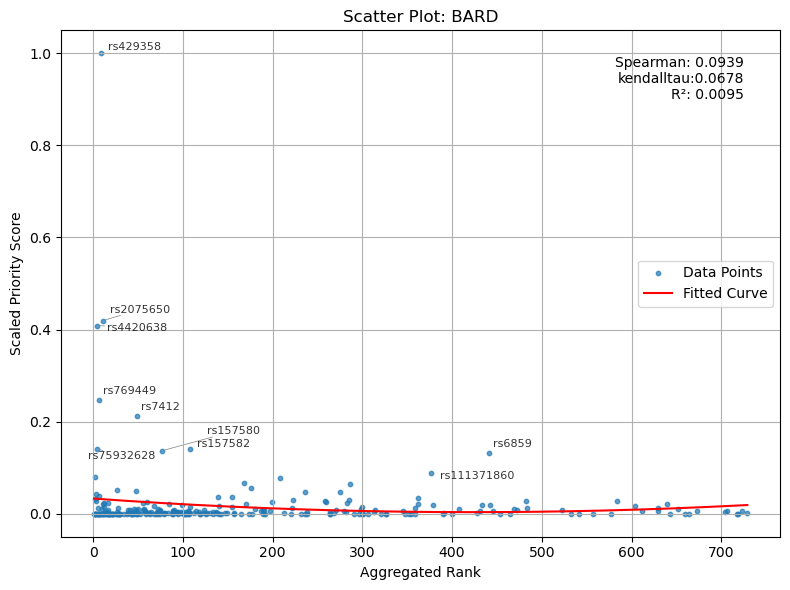

Results for big_aggregated_ranks20250106_122611.csv
Spearman Correlation: 0.0939
Pearson R2: 0.0095


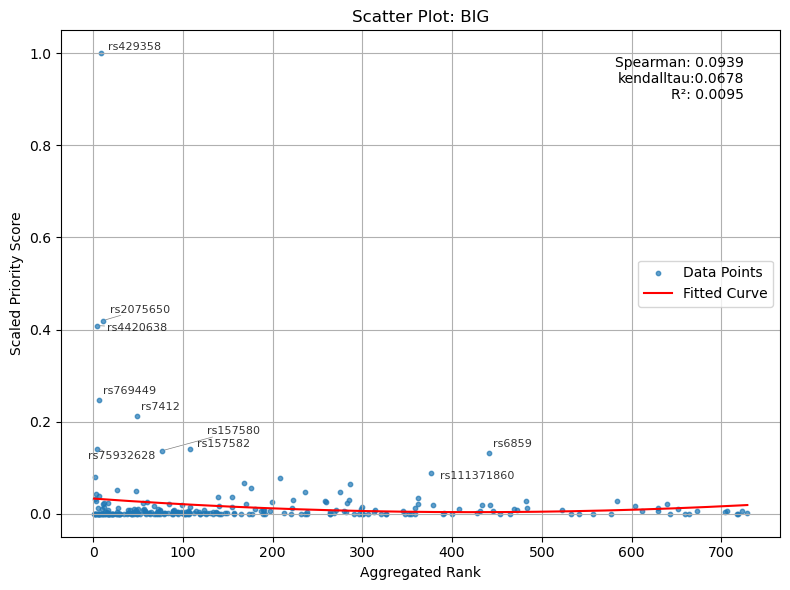

Results for birra_aggregated_ranks20250106_122609.csv
Spearman Correlation: 0.0939
Pearson R2: 0.0095


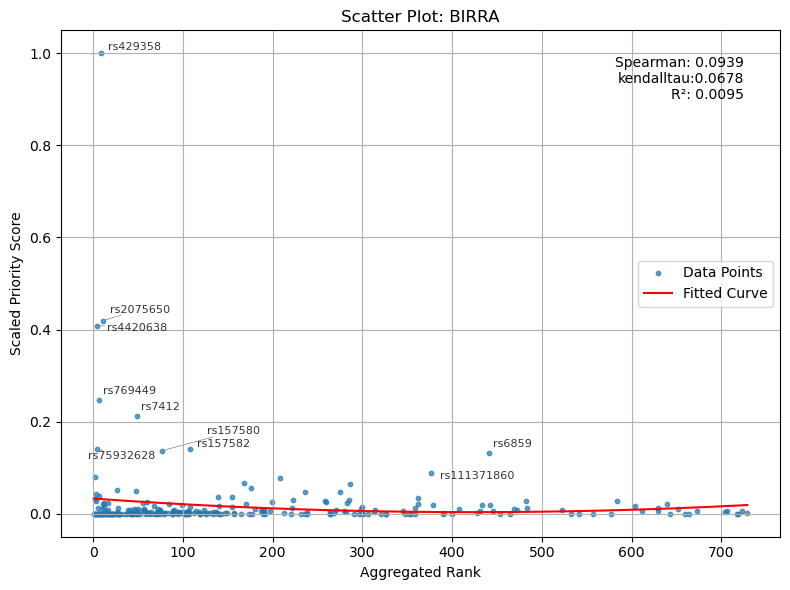

Results for cemc_kendall_aggregated_ranks20250106_122612.csv
Spearman Correlation: -0.0276
Pearson R2: 0.0023


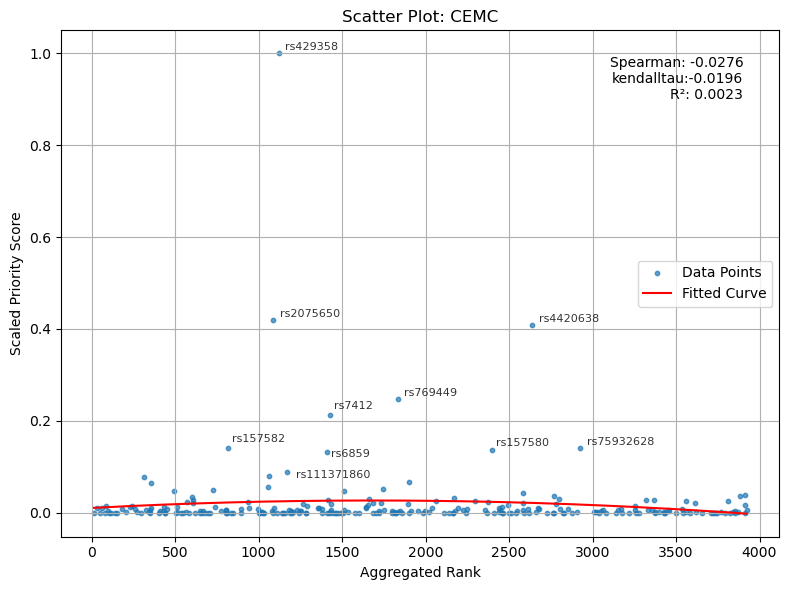

Results for cemc_spearman_aggregated_ranks20250106_123352.csv
Spearman Correlation: 0.0074
Pearson R2: 0.0008


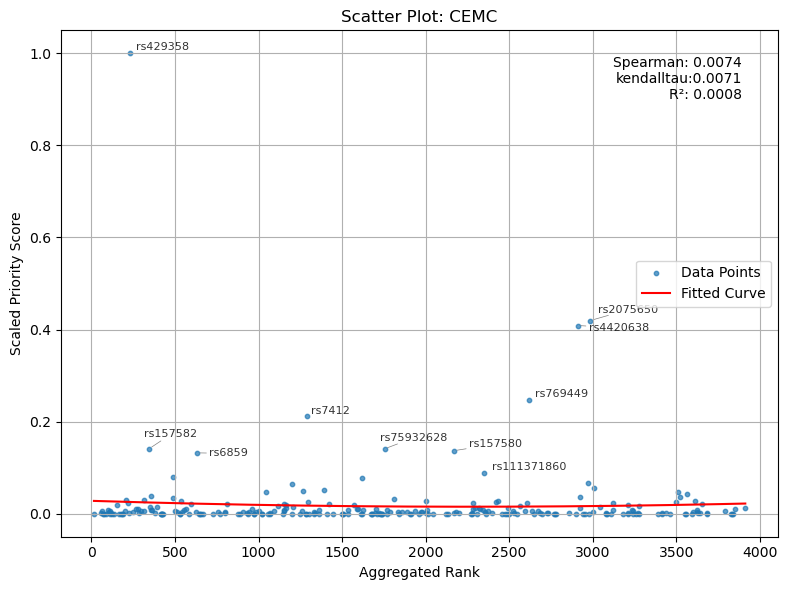

Results for geo_aggregated_ranks20250106_122552.csv
Spearman Correlation: -0.2863
Pearson R2: 0.0252


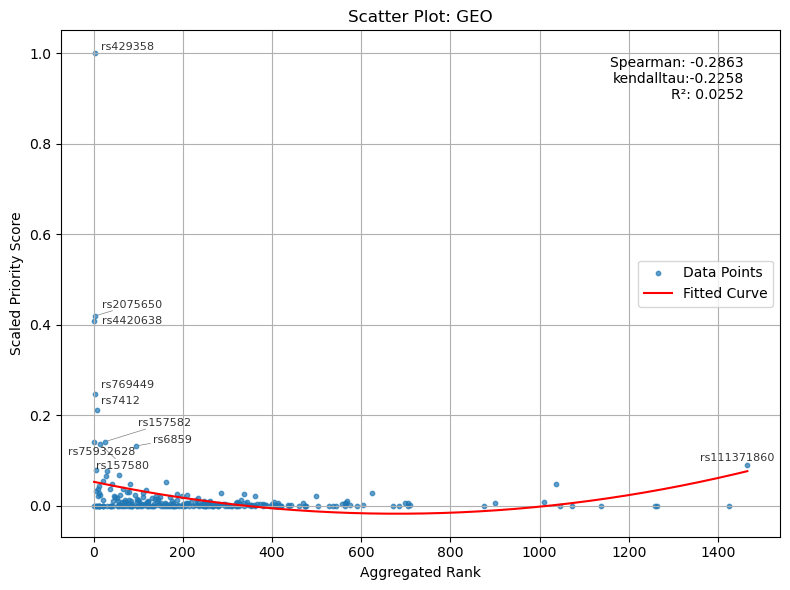

Results for l2_aggregated_ranks20250106_122554.csv
Spearman Correlation: -0.1545
Pearson R2: 0.0189


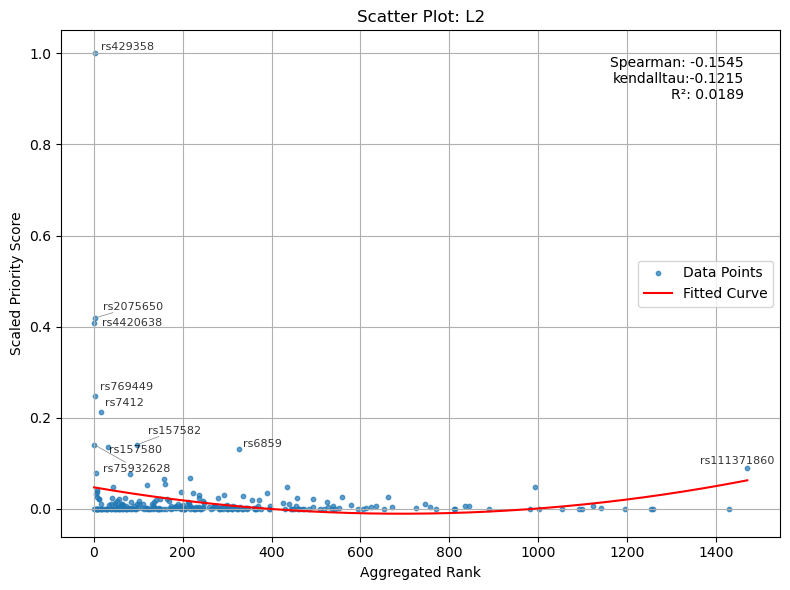

Results for mc1_aggregated_ranks20250106_122555.csv
Spearman Correlation: 0.0072
Pearson R2: 0.0296


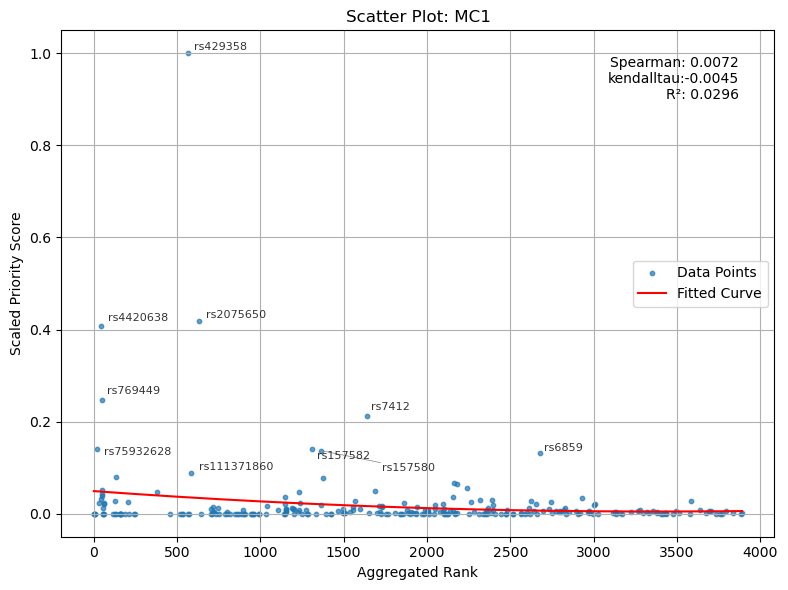

Results for mc2_aggregated_ranks20250106_122558.csv
Spearman Correlation: 0.0072
Pearson R2: 0.0296


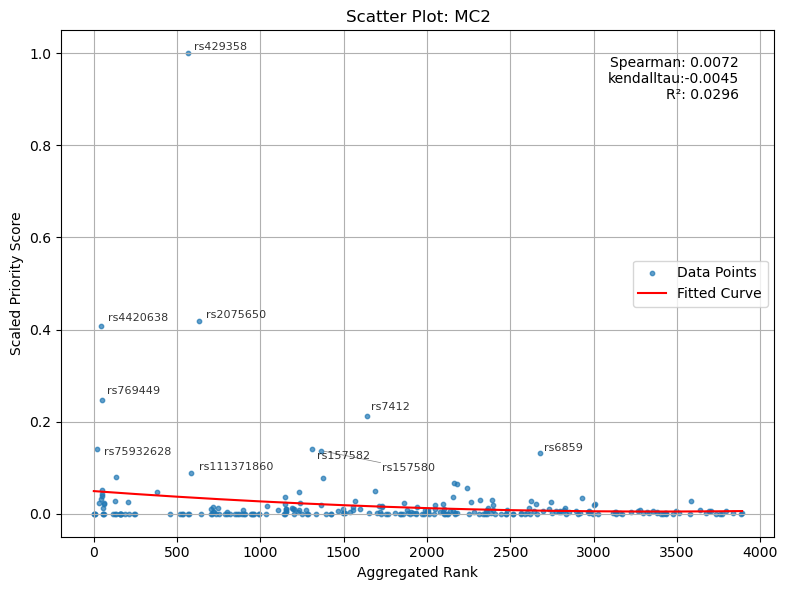

Results for mc3_aggregated_ranks20250106_122600.csv
Spearman Correlation: 0.0094
Pearson R2: 0.0314


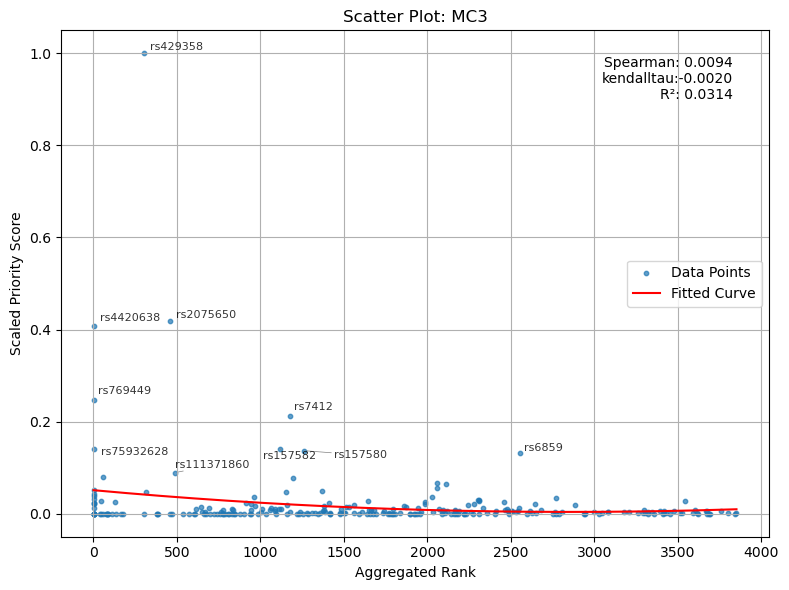

Results for mc4_aggregated_ranks20250106_122602.csv
Spearman Correlation: 0.0793
Pearson R2: 0.0217


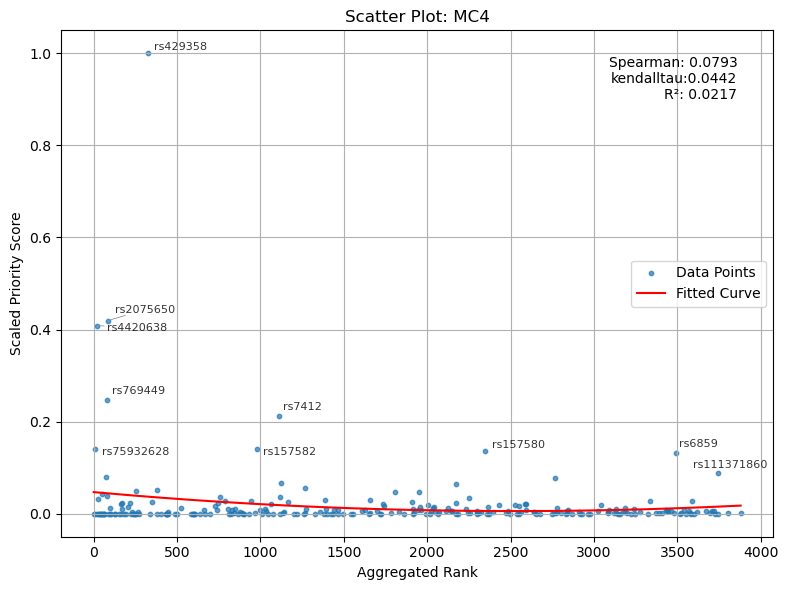

Results for mean_aggregated_ranks20250106_122549.csv
Spearman Correlation: -0.2260
Pearson R2: 0.0241


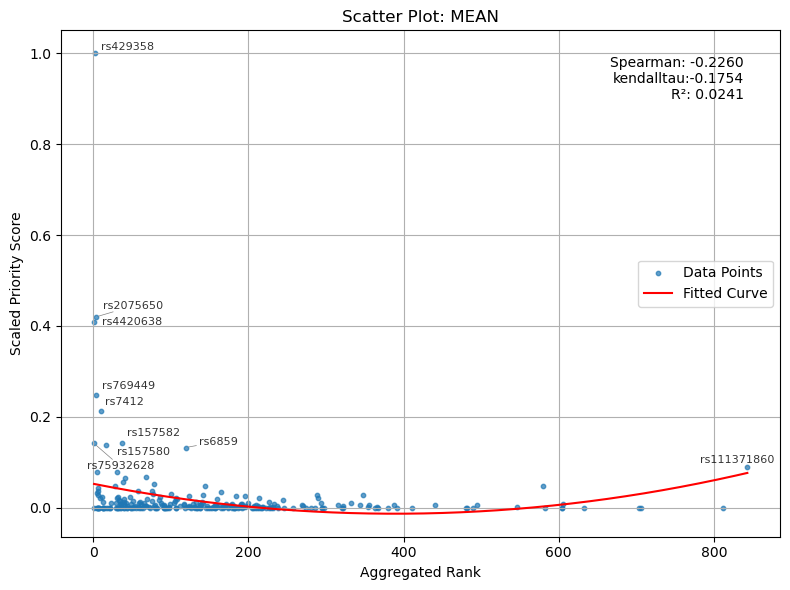

Results for med_aggregated_ranks20250106_122550.csv
Spearman Correlation: -0.3182
Pearson R2: 0.0181


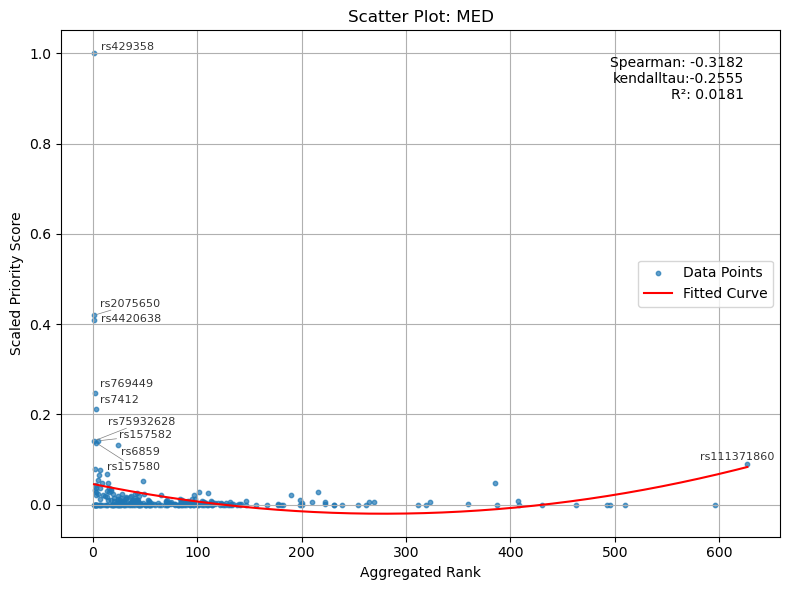

Results for rra_aggregated_ranks20250106_122607.csv
Spearman Correlation: -0.4730
Pearson R2: 0.0018


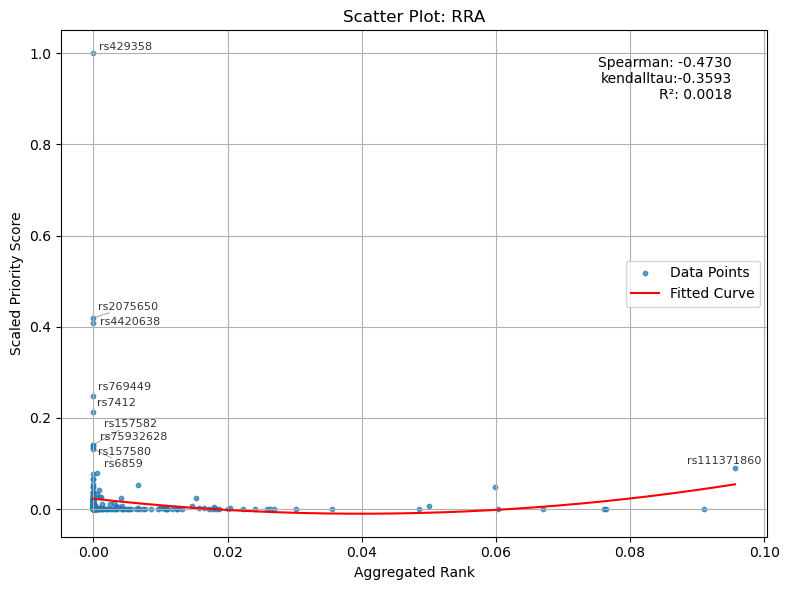

Results for stuart_aggregated_ranks20250106_122605.csv
Spearman Correlation: 0.0939
Pearson R2: 0.0095


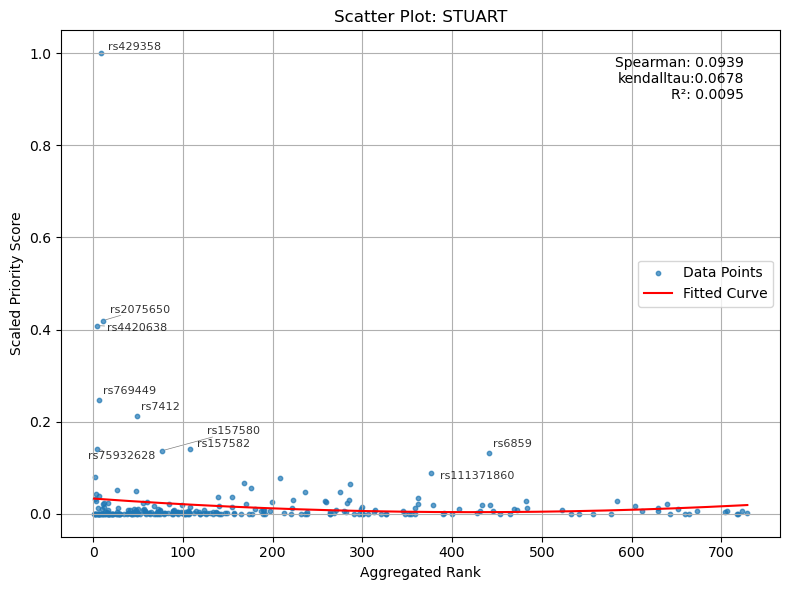

Results for thurstone_aggregated_ranks20250106_122604.csv
Spearman Correlation: -0.2260
Pearson R2: 0.0241


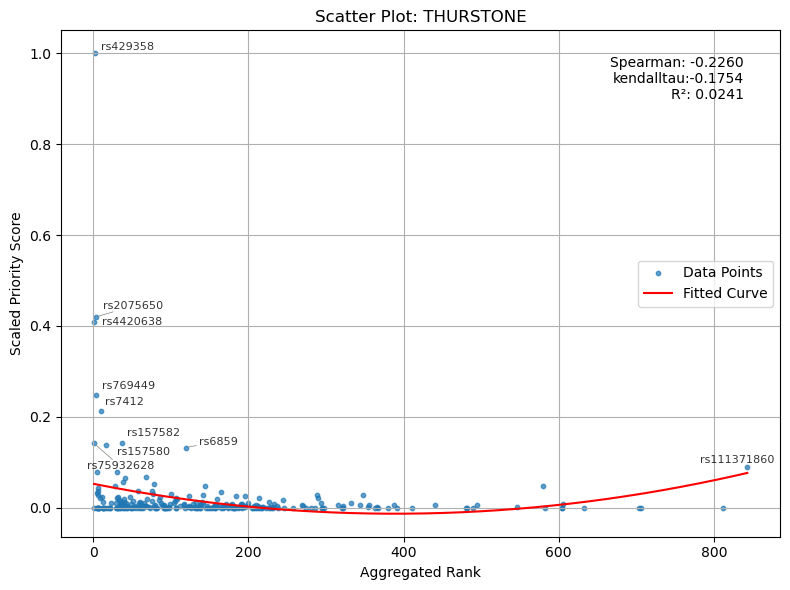

In [11]:


# Load the label file
label_df = pd.read_csv(os.path.join(directory, label_file))
label_df = label_df[['variant_id', 'priority_score']]  # Only consider variant_id and priority_score
label_df['priority_score'] = label_df['priority_score'].fillna(0)  # Set NaN in priority_score to 0

# Scale the priority score
min_score = label_df['priority_score'].min()
max_score = label_df['priority_score'].max()
label_df['priority_score'] = (label_df['priority_score'] - min_score) / (max_score - min_score)

# List all predicted files
predicted_files = [f for f in os.listdir(directory) if "_aggregated_ranks" in f and f.endswith(".csv")]

# Iterate over each predicted file
for predicted_file in predicted_files:
    # Load the predicted file
    predicted_df = pd.read_csv(os.path.join(directory, predicted_file))

    # Perform an inner join to align gene_variant_id with variant_id
    merged_df = predicted_df.merge(label_df, left_on='gene_variant_id', right_on='variant_id', how='inner')

    # Check if any overlapping gene_variant_id exist
    if merged_df.empty:
        print(f"No overlapping gene_variant_id between {predicted_file} and the label file.")
        continue

    # Extract aggregated rank and priority score
    predicted_rank = merged_df['aggregated_rank']
    priority_score = merged_df['priority_score']

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(predicted_rank, priority_score)

    # Calculate kendalltau correlation
    kendalltau_corr, _ = kendalltau(predicted_rank, priority_score)
    # Calculate Pearson R2
    pearson_corr, _ = pearsonr(predicted_rank, priority_score)
    r2 = pearson_corr ** 2

    # Print results
    print(f"Results for {predicted_file}")
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"Pearson R2: {r2:.4f}")

    # Plot the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted_rank, priority_score, alpha=0.7, s=10, label='Data Points')

    # Fit a polynomial curve (degree 2) and plot
    poly_fit = Polynomial.fit(predicted_rank, priority_score, deg=2).convert()
    coefs = poly_fit.coef
    x_vals = np.linspace(predicted_rank.min(), predicted_rank.max(), 500)
    y_vals = coefs[0] + coefs[1] * x_vals + coefs[2] * x_vals**2
    plt.plot(x_vals, y_vals, color='red', label='Fitted Curve')

    # Label the top 10 rsIDs by priority_score
    top_10 = merged_df.nlargest(10, 'priority_score')

    # Create text labels and optional arrows
    texts = []
    for _, row in top_10.iterrows():
        texts.append(
            plt.text(
                row['aggregated_rank'], 
                row['priority_score'], 
                row['variant_id'], 
                fontsize=8, 
                ha='left', 
                alpha=0.8
            )
        )
    
    # Automatically adjust labels to avoid overlaps
    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        only_move={'points': 'y', 'text': 'xy'},  # Move points vertically and text both x/y
    )

    # Add correlation coefficients to the plot (top-right corner)
    plt.text(
        0.95, 0.95, 
        f"Spearman: {spearman_corr:.4f}\nkendalltau:{kendalltau_corr:.4f}\nR²: {r2:.4f}",
        fontsize=10, 
        transform=plt.gca().transAxes, 
        verticalalignment='top', 
        horizontalalignment='right'
    )

    plt.title(f"Scatter Plot: {predicted_file.split('_')[0].upper()}")
    plt.xlabel("Aggregated Rank")
    plt.ylabel("Scaled Priority Score")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()  # Helps avoid clipping of labels
    # plt.savefig(os.path.join(directory, f"{predicted_file}_scatter_plot.png"))
    plt.show()


In [1]:
import pandas as pd

# Suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format
# Assuming the data is loaded into a DataFrame named df
df = pd.read_csv(r'C:\Users\gqu\OneDrive - UTHealth Houston\projects\Genevic\data\pgs_scores_data_summary-SB199944.csv')

# Grouping the data and calculating required statistics
df['Number of Variants'] = df['Number of Variants'].replace({',': ''}, regex=True)  # Remove commas
df['Number of Variants'] = pd.to_numeric(df['Number of Variants'], errors='coerce')  # Convert to numeric

# Check for and handle any NaN values that may have resulted from invalid conversions
df = df.dropna(subset=['Number of Variants'])

# Grouping the data and calculating required statistics
summary = df.groupby(['MegaCategory']).agg(
    Count=('Number of Variants', 'size'),
    Mean_Variants=('Number of Variants', 'mean'),
    Median_Variants=('Number of Variants', 'median'),
    Min_Variants=('Number of Variants', 'min'),
    Max_Variants=('Number of Variants', 'max')
).reset_index()

# Print the summary table
print(summary)

# Optionally, save the summary to a CSV file
# summary.to_csv('summary_statistics.csv', index=False)


                       MegaCategory  Count  Mean_Variants  Median_Variants  \
0                          Bayesian      4     1063306.75       1100622.00   
1  Genome-wide significant variants     17          40.94            39.00   
2                             Other      8       88197.25            36.50   
3                              PC+T     15       18786.67            85.00   
4              Penalized regression      8      131585.25            22.50   

   Min_Variants  Max_Variants  
0        915771       1136212  
1            11            83  
2            10        691136  
3             8        249273  
4             6       1046908  


In [7]:
numbers = [1.063307e+06, 1100622.0, 915771, 1136212,  691136, 249273, 1046908 ]

# Convert numbers to scientific notation
formatted_numbers = ['{:.3e}'.format(num) for num in numbers]

# Printing formatted numbers
print(formatted_numbers)

['1.063e+06', '1.101e+06', '9.158e+05', '1.136e+06', '6.911e+05', '2.493e+05', '1.047e+06']


In [10]:
def extract_rsid_lists(csv_path, rsid_col='Top 200 rsIDs'):
    """
    Reads a CSV file containing a 'Top 200 rsIDs' column of comma-separated rsIDs,
    and extracts them as lists.

    Args:
        csv_path (str): Path to the CSV file.
        rsid_col (str): Name of the column containing comma-separated rsIDs.

    Returns:
        pd.DataFrame: A DataFrame where the rsID column is replaced with lists.
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Parse the 'Top 200 rsIDs' column into lists by splitting on commas
    df[rsid_col] = df[rsid_col].apply(lambda x: [rs.strip() for rs in x.split(',')] if pd.notnull(x) else [])

    return df


In [11]:
csv_file_path = r"C:\Users\gqu\OneDrive - UTHealth Houston\projects\Genevic\scirpt\Notebook\summary_new.csv"

# Extract the data with each 'Top 200 rsIDs' as a list
data_with_lists = extract_rsid_lists(csv_file_path, rsid_col='Top 1000 rsIDs')

In [12]:
from Bio import Entrez
Entrez.email = 'adamrt9319@gmail.com'
def get_genes(common_rsIDs):
    for snp_id in common_rsIDs:
        numeric_id = snp_id.replace('rs', '')
        record = Entrez.read(Entrez.elink(dbfrom="snp",
                                          id=numeric_id,
                                          db="gene"))
        # Check if LinkSetDb and links are present
        if 'LinkSetDb' in record[0] and len(record[0]['LinkSetDb']) > 0:
            links = record[0]['LinkSetDb'][0]['Link']
            for gene_link in links:
                gene_id = gene_link['Id']
                handle = Entrez.esummary(db="gene", id=gene_id)
                uid_record = Entrez.read(handle)
                handle.close()
    
                uid_summary = uid_record["DocumentSummarySet"]['DocumentSummary'][0]
                print(snp_id, gene_id, uid_summary['Name'])
        else:
            print(f"No gene links found for {snp_id}")


In [13]:
common_rsIDs = data_with_lists.iloc[35]['Top 1000 rsIDs'][:100]

In [14]:
get_genes(common_rsIDs)

rs429358 348 APOE
rs2075650 10452 TOMM40
rs4420638 341 APOC1
rs769449 348 APOE
rs7412 348 APOE
rs157582 10452 TOMM40
rs75932628 105375056 LOC105375056
rs75932628 54209 TREM2
rs157580 10452 TOMM40
rs6859 5819 NECTIN2
No gene links found for rs111371860
rs28399637 4059 BCAM
rs6733839 105373605 LOC105373605
rs405509 348 APOE
rs11218343 6653 SORL1
rs1160985 10452 TOMM40
rs6857 5819 NECTIN2
rs405697 10452 TOMM40
No gene links found for rs78986976
No gene links found for rs10792832
rs143080277 8440 NCK2
rs10004266 23158 TBC1D9
rs10005919 105377557 LOC105377557
No gene links found for rs10010272
rs1001530 105377750 FAM193B-DT
No gene links found for rs1001776
rs10034594 50859 SPOCK3
rs10038689 10087 CERT1
No gene links found for rs10039851
rs1004173 23607 CD2AP
rs10051466 79772 MCTP1
No gene links found for rs1005972
rs1006054 6900 CNTN2
rs10060770 105379076 LINC02161
rs10061009 101929768 OSMR-DT
No gene links found for rs1006318
No gene links found for rs10063762
rs10064888 107984118 LOC1079

In [29]:
def get_top_variants(file_path, N):
    """
    Extract the top N ranked variants from a CSV file.

    Args:
        file_path (str): Path to the CSV file containing the dataset.
        N (int): Number of top-ranked variants to return.

    Returns:
        pd.DataFrame: A DataFrame containing the top N variants sorted by rank.
    """
    # Load the dataset
    df = pd.read_csv(file_path)  # Adjust separator if necessary
    print(df)
    # Ensure the data is sorted by aggregated_rank
    df_sorted = df.sort_values(by="aggregated_rank", ascending=True)

    # Select the top N rows
    top_variants = df_sorted.head(N)

    return top_variants

# Example usage
file_path = r"C:\Users\gqu\OneDrive - UTHealth Houston\projects\Genevic\scirpt\logs\unsup\mc3_aggregated_ranks20250106_122600.csv"
N = 100  # Replace with the desired number of top variants
top_variants = get_top_variants(file_path, N)
print(top_variants)

     gene_variant_id  aggregated_rank
0         rs10004266             2643
1         rs10005919             1558
2         rs10010272             3256
3          rs1001530             2504
4          rs1001776             3121
...              ...              ...
3936       rs9972911             1715
3937       rs9973305             2136
3938       rs9979235             1926
3939       rs9983156              953
3940       rs9994784             1526

[3941 rows x 2 columns]
     gene_variant_id  aggregated_rank
599      rs117394726                1
257        rs1106639                1
1341        rs157591                1
1339        rs157583                1
2784      rs62109573                1
...              ...              ...
2283       rs3812908               16
3086      rs72364644               17
169       rs10760502               18
3257       rs7447815               19
1724       rs2074071               20

[100 rows x 2 columns]


In [32]:
get_genes(top_variants["gene_variant_id"].to_list())

C:\ProgramData\anaconda3\Lib\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


rs117394726 100507206 LINC00943
rs117394726 387895 LINC00944
rs1106639 728294 D2HGDH
No gene links found for rs157591
rs157583 10452 TOMM40
rs62109573 4099 MAG
rs34095326 10452 TOMM40
rs157581 10452 TOMM40
rs72824905 5336 PLCG2
No gene links found for rs11111149
No gene links found for rs11882065
rs150685845 79090 TRAPPC6A
rs79644719 22848 AAK1
rs112019714 10452 TOMM40
No gene links found for rs28615360
rs60755019 107986595 LOC107986595
rs79816395 105376942 LOC105376942
rs141342242 729171 ANKRD20A8P
rs4420638 341 APOC1
rs11260622 2782 GNB1
rs28660482 2044 EPHA5
rs76920613 114991 ZNF618
No gene links found for rs141622900
rs72942081 105377949 LOC105377949
No gene links found for rs71424358
No gene links found for rs76367405
No gene links found for rs138604348
rs75607373 440279 UNC13C
rs9516245 10082 GPC6
rs6857 5819 NECTIN2
rs4910844 390072 OR52N4
rs4893 2014 EMP3
rs60340772 7171 TPM4
rs60257121 100873973 GPC6-AS2
rs60257121 10082 GPC6
rs13159296 115827 RAB3C
rs34779859 105373605 LOC105

In [ ]:
bench_mark = []

In [6]:
from scipy.stats import ttest_rel
def pair_ttest(A, B):
    return ttest_rel(A, B)

In [7]:
import pandas as pd
df = pd.read_csv("summary_new.csv")

# Group data by model and extract MSE and R2 lists
model_data = {}
for model, group in df.groupby('Model'):
    model_data[model] = {
        'MSE': group['MSE'].tolist(),
        'R2': group['R2 Score'].tolist()
    }



In [13]:
import numpy as np
NN_MSE = [0.9103125002336792,
   0.9325550232126176,
   0.9231246813883012,
   0.9142221826734762,
   0.9310093599899129,
   0.9257106382867374,
   0.9182163041040138,
   0.9194876600064112,
   0.9306302579502126,
   0.9192816735573002]
NN_R2 = [0.3512997428234847,
   0.3354494382599553,
   0.342169619697787,
   0.3485136534272348,
   0.3365508975168803,
   0.3403268339460452,
   0.3456673917330157,
   0.3447614073588186,
   0.3368210504485235,
   0.3449081959204157]

rf_MSE = [0.9850207692865496,
   0.9958052902112298,
   0.9914628051550542,
   1.005605220888353,
   0.9960438627014848,
   0.991326014637258,
   0.9888001868696475,
   0.9867381609729208,
   0.994013519176693,
   0.9852270035472154]
rf_R2 = [0.2980616808004227,
   0.2903764941248913,
   0.2934710041662267,
   0.2833929389733034,
   0.2902064843362265,
   0.2935684828277315,
   0.2953684197966424,
   0.2968378456577263,
   0.2916533329364061,
   0.2979147156451621]
print(np.mean(NN_MSE))
print(np.mean(rf_MSE))
print(pair_ttest(NN_MSE, rf_MSE))

0.9224550281402661
0.9920042833446407
TtestResult(statistic=-26.128074865559327, pvalue=8.504183391031732e-10, df=9)


In [8]:
model_data

{'decision_tree': {'MSE': [1.1930488371797372,
   1.2864696306242074,
   1.2304145700097082,
   1.194075196922216,
   1.1940751969260806,
   1.2491007577050577,
   1.268827543876143,
   1.1940960782277945,
   1.1764331101818806,
   1.2677803028358146],
  'R2': [0.1479614888320725,
   0.0812432529325968,
   0.1212760402762472,
   0.1472284945072368,
   0.147228494504477,
   0.1079309440428134,
   0.0938426846224594,
   0.1472135817258302,
   0.1598279261915798,
   0.0945905917231819]},
 'lasso': {'MSE': [1.3993598618220466,
   1.3993598618220466,
   1.3993598618220466,
   1.3993598618220466,
   1.3993598618220466,
   1.3993598618220466,
   1.3993598618220466,
   1.3993598618220466,
   1.3993598618220466,
   1.3993598618220466],
  'R2': [0.0006205478783868,
   0.0006205478783868,
   0.0006205478783868,
   0.0006205478783868,
   0.0006205478783868,
   0.0006205478783868,
   0.0006205478783868,
   0.0006205478783868,
   0.0006205478783868,
   0.0006205478783868]},
 'linear_regression': {'M

In [9]:
NN_MSE = model_data['neural_network']['MSE']
NN_R2 = model_data['neural_network']['R2']
for model in model_data:
    if model != "neural_network":
        MSE = model_data[model]['MSE']
        R2 = model_data[model]['R2']
        print('Model:', model)
        print("mse p-value:", pair_ttest(NN_MSE, MSE))
        print("R2 p-value:", pair_ttest(NN_R2, R2))

Model: decision_tree
mse p-value: TtestResult(statistic=-24.293490713686396, pvalue=1.6239385017093092e-09, df=9)
R2 p-value: TtestResult(statistic=24.293490713686406, pvalue=1.623938501709303e-09, df=9)
Model: lasso
mse p-value: TtestResult(statistic=-155.58179575054135, pvalue=9.51878128071273e-17, df=9)
R2 p-value: TtestResult(statistic=155.58179575054137, pvalue=9.518781280712664e-17, df=9)
Model: linear_regression
mse p-value: TtestResult(statistic=-333.8111720645236, pvalue=9.890529223486787e-20, df=9)
R2 p-value: TtestResult(statistic=333.8111720645228, pvalue=9.890529223486997e-20, df=9)
Model: random_forest
mse p-value: TtestResult(statistic=-34.94887032735496, pvalue=6.352265592356983e-11, df=9)
R2 p-value: TtestResult(statistic=34.948870327355046, pvalue=6.352265592356824e-11, df=9)
Model: ridge
mse p-value: TtestResult(statistic=-322.52736763754353, pvalue=1.3477767976836258e-19, df=9)
R2 p-value: TtestResult(statistic=322.52736763754274, pvalue=1.3477767976836643e-19, df=9